In [27]:
import pandas as pd
import numpy as np
import re
from datetime import date
import datetime
import calendar
import holidays
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
calendar_df = pd.read_csv("calendar.csv")
calendar_df.fillna(0, inplace=True)
calendar_df = calendar_df[calendar_df.price != 0]

In [18]:
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
9,241032,2016-01-13,t,$85.00
10,241032,2016-01-14,t,$85.00
14,241032,2016-01-18,t,$85.00


In [19]:
price = calendar_df['price']
prices=[]

for p in price:
    p = re.sub('[^0-9.]+','', p)
    prices.append(float(p))

# Replacing Price Column
calendar_df['price']=prices
calendar_df = calendar_df[calendar_df.price >= 0]

# Separating Date Column Into Months and Days
calendar_df['Year'], calendar_df['Month'], calendar_df['Day']= calendar_df['date'].str.split('-',2).str
calendar_df.head()

<ipython-input-19-bf98703df4c1>:13: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  calendar_df['Year'], calendar_df['Month'], calendar_df['Day']= calendar_df['date'].str.split('-',2).str


,listing_id,date,available,price,Year,Month,Day
0,241032,2016-01-04,t,85.0,2016,01,04
1,241032,2016-01-05,t,85.0,2016,01,05
9,241032,2016-01-13,t,85.0,2016,01,13
10,241032,2016-01-14,t,85.0,2016,01,14
14,241032,2016-01-18,t,85.0,2016,01,18


### Let's analyze the average price for each month

In [20]:
year=calendar_df.groupby(['Year','Month']).price.mean()
year=year.reset_index()
year=year.rename(columns={'price':'average_Price'})
year['year-Month']=year['Year'].map(str) + "-" + year['Month'].map(str)
year

,Year,Month,average_Price,year-Month
0,2016,01,121.568409,2016-01
1,2016,02,124.293927,2016-02
2,2016,03,128.644488,2016-03
3,2016,04,135.097005,2016-04
4,2016,05,139.538183,2016-05
5,2016,06,147.473137,2016-06
6,2016,07,152.094150,2016-07
7,2016,08,150.656594,2016-08
8,2016,09,143.255949,2016-09
9,2016,10,137.031939,2016-10


It can be seen that July had the highest average prices, and the data spans one year

### Now let's look at a breakdown of price by weekday

In [21]:
calendar_df.fillna(0, inplace=True)
us_holidays = holidays.UnitedStates()

calendar_df['day_Name']='default'
calendar_df['holiday']='False'
calendar_df['us_holidays_name']='working'
for index,row in calendar_df.iterrows():
    sdate = datetime.date(int(row['Year']),int(row['Month']),int(row['Day']))
    vall=date(int(row['Year']),int(row['Month']),int(row['Day'])) in us_holidays
    calendar_df.at[index,'day_Name'] = calendar.day_name[sdate.weekday()]
    calendar_df.at[index,'holiday'] = vall
    calendar_df.at[index,'us_holidays_name'] = us_holidays.get(sdate)
calendar_df.head()

,listing_id,date,available,price,Year,Month,Day,day_Name,holiday,us_holidays_name
0,241032,2016-01-04,t,85.0,2016,01,04,Monday,False,None
1,241032,2016-01-05,t,85.0,2016,01,05,Tuesday,False,None
9,241032,2016-01-13,t,85.0,2016,01,13,Wednesday,False,None
10,241032,2016-01-14,t,85.0,2016,01,14,Thursday,False,None
14,241032,2016-01-18,t,85.0,2016,01,18,Monday,True,Martin Luther King Jr. Day


In [23]:
dayDF=calendar_df.groupby('day_Name').price.mean()
dayDF=dayDF.reset_index()
dayDF['day_num']=0

for index,row in dayDF.iterrows():
    if row['day_Name']=='Monday':
        dayDF.at[index,'day_num']=1
    if row['day_Name']=='Tuesday':
        dayDF.at[index,'day_num']=2
    if row['day_Name']=='Wednesday':
        dayDF.at[index,'day_num']=3
    if row['day_Name']=='Thursday':
        dayDF.at[index,'day_num']=4
    if row['day_Name']=='Friday':
        dayDF.at[index,'day_num']=5
    if row['day_Name']=='Saturday':
        dayDF.at[index,'day_num']=6
    if row['day_Name']=='Sunday':
        dayDF.at[index,'day_num']=7
dayDF=dayDF.sort_values('day_num',ascending=[1])
dayDF=dayDF.rename(columns={'price':'Average_Price'})

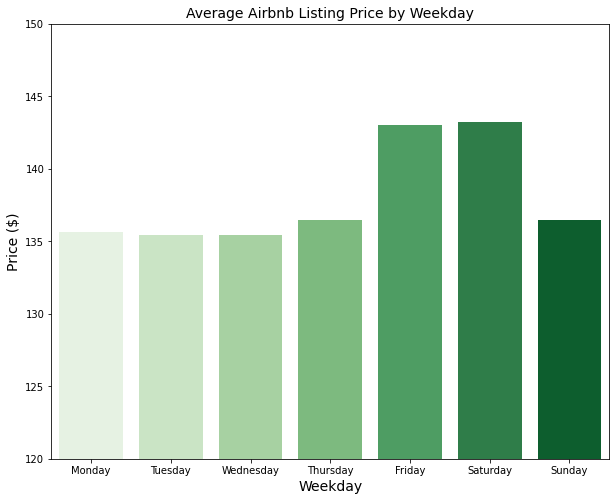

In [115]:
plt.figure(figsize=(10,8))
ax = sns.barplot(data=dayDF, x="day_Name", y="Average_Price", palette='Greens')
ax.set_title('Average Airbnb Listing Price by Weekday', fontsize=14)
ax.set_ylabel('Price ($)', fontsize=14)
ax.set_xlabel('Weekday', fontsize=14)
ax.set(ylim=(120, 150))
plt.show()

### Let's get a price breakdown of prices by holiday

In [80]:
holidayPriceDF=calendar_df.groupby('us_holidays_name').price.mean()
holidayPriceDF=holidayPriceDF.reset_index()
holidayPriceDF=holidayPriceDF.sort_values('price',ascending=[0])
holidayPriceDF

,us_holidays_name,price
3,Independence Day,151.402362
6,Memorial Day,143.233837
4,Labor Day,142.087264
10,Veterans Day,140.070272
7,New Year's Day,138.126968
0,Christmas Day,137.974903
1,Christmas Day (Observed),137.895797
9,Thanksgiving,136.054989
8,New Year's Day (Observed),135.572767
2,Columbus Day,134.985660


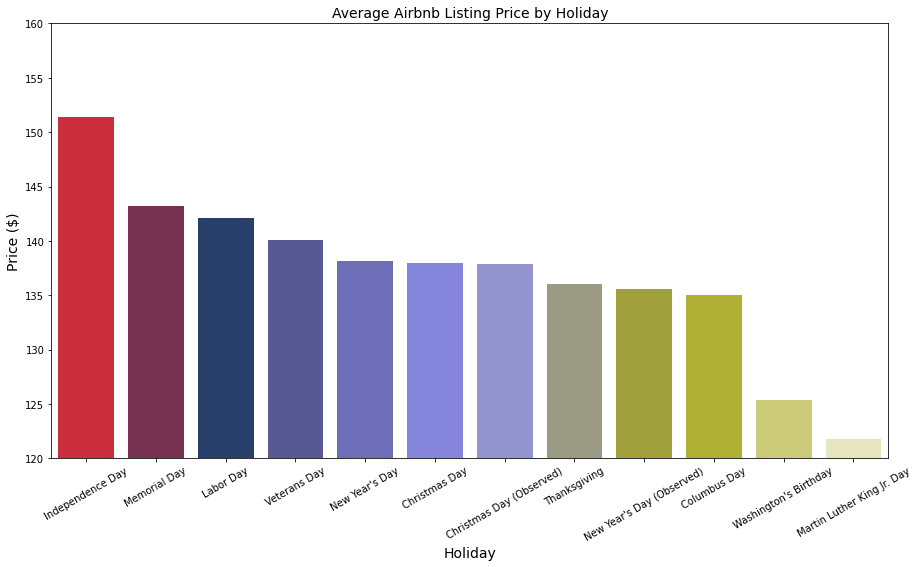

In [116]:
plt.figure(figsize=(15,8))
ax = sns.barplot(data=holidayPriceDF, x="us_holidays_name", y="price", palette='gist_stern')
ax.set_title('Average Airbnb Listing Price by Holiday', fontsize=14)
ax.set_ylabel('Price ($)', fontsize=14)
ax.set_xlabel('Holiday', fontsize=14)
ax.set(ylim=(120, 160))
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()